# 🍏 Welcome to the **Smart Droplets Hackathon**!

![image](assets/sd_logo.png)

The Smart Droplets project is an EU-funded project, focusing on achieving reduced pesticide and fertilizer use with techniques of Digital Twins and Reinforcement Learning. One of the pilot projects of Smart Droplets is about the reduction of the **apple scab** pest.
In commercial apple production, **apple scab (_Venturia inaequalis_)** is the most economically important disease. Growers traditionally rely on **calendar-based fungicide programs**, which can lead to unnecessary sprays, resistance, and environmental impact.
In this hackathon we’ll flip that paradigm: **you will train a reinforcement-learning (RL) agent, or an intelligent conditional agent, to decide _when_ (and _how much_) to spray, balancing disease risk with sustainability.**

---

## 🧩 The Challenge

**Goal**: **Learn an optimal and adaptive spraying policy.**

**How to achieve that?**: Use **RL** to interact with the **A-scab** disease simulator. Your agent chooses daily actions (“spray how much” vs. “don’t spray”) through an entire season, to reduce the risk of breakout.

**Why is this important?** Smarter timing reduces chemical use, lowers costs, and lowers environmental impact while keeping orchards healthy to reduce yield loss.

Success is measured by a **cumulative reward**:

$R_t = - Risk_{t} - \beta P_t$

* $Risk$ is **Infection risk** – cumulative infection severity at harvest
* $\beta$ is **trade-off coefficient** - coefficient describing economic and ecological price of pesticides
* $P$ is **Pesticide amount** – the amount of pesticide sprayed

A higher score is better -- closer to zero!

---

## 🌱 The Environment: **Ascabgym**

Ascabgym is a stochastic, weather-driven model of apple scab dynamics, based on the A-scab model.
At each daily time step, an agent can observe the following features:

* _Weather features_: Temperature, relative humidity, rainfall, and leaf wetness
    * also 1 day and 2 day forecasts of the above weather features
* _Pest features_: ascopore maturity & development
* _Tree features_: leaf area index and phenology

…and updates disease progress based on your action. We expose a **Gymnasium-style API** so you can plug in any RL library (Stable-Baselines3, RLlib, CleanRL, etc.).

---

## 📂 Data & Starter Kit

* **Historical weather files** for training the model, files from several locations in Europe (CSV).
* **Default orchard parameters** which are already embedded in the model
* Performance of baseline agents to beat!

% Clone the repo or fork the Kaggle notebook, pip-install extra libraries as needed, and start experimenting.

---

## 🏆 Evaluation & Leaderboards

1. **Local validation** – run episodes on the provided weather years (fast iteration).
2. **Public leaderboard** – on submission, Kaggle simulates **four hidden seasons** from a particular location and reveals your average score.
3. **Private leaderboard** (final ranking) – after the deadline we evaluate on **five additional unseen seasons** to prevent overfitting.

> **Tip:** Aim for generalisation, not leaderboard-hacking!

---

## ✋ Rules of the Game

| Topic | Rule                                                                                               |
|-------|----------------------------------------------------------------------------------------------------|
| **External data** | In general, the use of external data is not allowed.                                               |
| **Compute** | Submissions must run < **3 hours on Kaggle’s 2×V100** quota.                                       |
| **Team size** | Individual!                                                                                        |
| **Fair play** | No model-sharing between teams until after the hackathon closes. Respect Kaggle’s Code of Conduct. |

---

## 🛠️ Resources

* **A-scab docs** (PDF + API reference)
* **RL documentation** (Stable Baselines 3 documentation)

---


## 🚀 First things first

Install all the necessary packages. Feel free to install the RL framework you feel most comfortable working with. By default, you can use Stable Baselines 3. Make sure to install the hackathon version of the A-scab repository.

In [ ]:
from mpmath import hyper
#clone the repository and install AscabGym
!rm -rf A-scab/
!git clone -b hackathon https://github.com/WUR-AI/A-scab.git
#change directory
%cd A-scab
#install poetry if needed.
!pip install -qqq poetry

#install; this step may take 5 minutes
!poetry config virtualenvs.in-project true
!poetry install --quiet --all-extras

# These are things you don't need to know about for now :)
import os, sys

VENV_PATH = "/content/A-scab/.venv/lib/python3.11/site-packages"
LOCAL_VENV_PATH = '/content/venv' # local notebook
os.symlink(VENV_PATH, LOCAL_VENV_PATH) # connect to directory in drive
sys.path.insert(0, LOCAL_VENV_PATH)

In [ ]:
# install further packages using poetry, to keep package dependency intact
# in general the syntax is `poetry add PACKAGE_NAME`, then install with `poetry install`.
# below is an example how to install (rllib)[https://docs.ray.io/en/latest/rllib/rllib-algorithms.html

# note: you don't have to install it now for this notebook!
!poetry add ray[rllib]
!poetry install

 Initialize the gymnasium environment by importing the necessary methods. You must do `import ascab` in this hackathon!

This may take 1 minute or so :)

In [1]:
import os
import ascab
import gymnasium as gym

Please wait a few seconds; importing the AscabGym modules...
Imported successfully!


For this hackathon, we have provided pre-registered environments that you will only need the ID to call. For example, the code below will construct the AscabGym environment!

In [2]:
ascab_train = gym.make('AscabTrainEnv-Discrete')

The code below will be your validation gym environment, i.e., the place where you test your trained agents! (Note the different environment id)

In [3]:
ascab_val = gym.make('AscabValEnv-Discrete')

Additionally, if you don't plan on training an RL agent, please use the environment below:

In [4]:
ascab_val_nonrl = gym.make('AscabValEnv-Continuous-NonRL')

# Let's get to know the Ascab environment! (_Gym speed dating?_)

We're gonna introduce to you the _action space_, the _observation space_ and the _goal_ of the A-scab gym environment!

### Action space, A.K.A what your agent can do!

with the code below, you can check what the agent can do in each timestep!

In [5]:
print(ascab_train.action_space)

Discrete(6)


Notice that it is a discrete action space of 6? This corresponds to the following amounts: $ A = \{0.2\,i\,|\,i=0,1,2,\dots,6\}$.

You can also use a continuous action spaces, which will have actions of [0, 1]! That will allow the agent to have a more fine-grained decision when spraying.

_hint: initialize the environment with `gym.make(AscabTrainEnv-Continuous')`_

Let's try checking what the agent can do: let's sample an action:


In [6]:
# Try running this cell a few times: you should see different things the agent can do in the AscabGym!
print(ascab_train.action_space.sample())

5


See different numbers pop up? What do they mean? Remember the formula above! 1 means the agent sprays 0.2 pesticide at that day, and so on. 0 just means the agent did not spray at all.

### Observation space, A.K.A what your agent can see!

The in general, the agent can see these following features:

#### *Fungus (n = 2)*

| Feature           | Description                                                      | Units |
|-------------------|------------------------------------------------------------------|-------|
| InfectionWindow   | An indicator of whether the simulation goes in the risk period   | -     |
| SRA_discharge     | Portion of ascopores becoming airborne during a discharge event  | -     |

#### *RL Agent (n = 4)*

| Feature           | Description                                                      | Units |
|-------------------|------------------------------------------------------------------|-------|
| AppliedPesticide  | Total amount of applied pesticide                                | -     |
| ActionHistory     | Total number of spraying events in the growing season            | -     |
| RemainingSprays   | Indicator of number of spraying events left                      | -     |
| β (beta)          | Trade-off coefficient[^a]                                        | -     |

#### *Host (n = 1)*

| Feature         | Description                            | Units |
|------------------|----------------------------------------|-------|
| LAI              | Leaf Area Index                        | -     |

#### *Weather (n = 15)*

| Feature         | Description                                                                 | Units   |
|------------------|-----------------------------------------------------------------------------|---------|
| LWD              | Leaf wetness duration                                                       | hours   |
| Precip           | Amount of precipitation                                                     | mm      |
| Temp             | Average temperature                                                         | °C      |
| HasRainEvent     | Presence of significant rainfall (≥ 0.2 mm/h)                               | -       |
| HighHumDur       | Hours of high humidity (≥ 85%)                                              | hours   |

---

[^a]: Used in the reward function.
[^b]: Weather variables are computed for the current day and the two-day forecast (5 variables × 3 days), aggregated over 24 hours.

You can also check this through code:


In [7]:
print(ascab_train.observation_space)

Dict('ActionHistory': Box(0.0, inf, (), float32), 'AppliedPesticide': Box(0.0, inf, (), float32), 'Beta': Box(0.0, inf, (), float32), 'Discharge': Box(0.0, inf, (), float32), 'Forecast_day1_HasRain': Box(0.0, inf, (), float32), 'Forecast_day1_HumidDuration': Box(0.0, inf, (), float32), 'Forecast_day1_LeafWetness': Box(0.0, inf, (), float32), 'Forecast_day1_Precipitation': Box(0.0, inf, (), float32), 'Forecast_day1_Temperature': Box(0.0, inf, (), float32), 'Forecast_day2_HasRain': Box(0.0, inf, (), float32), 'Forecast_day2_HumidDuration': Box(0.0, inf, (), float32), 'Forecast_day2_LeafWetness': Box(0.0, inf, (), float32), 'Forecast_day2_Precipitation': Box(0.0, inf, (), float32), 'Forecast_day2_Temperature': Box(0.0, inf, (), float32), 'HasRain': Box(0.0, inf, (), float32), 'HumidDuration': Box(0.0, inf, (), float32), 'InfectionWindow': Box(0.0, inf, (), float32), 'LAI': Box(0.0, inf, (), float32), 'LeafWetness': Box(0.0, inf, (), float32), 'Precipitation': Box(0.0, inf, (), float32), '

A bit confusing maybe, but each dictionary key represents the features, or what your RL agent can "see". It directly maps from the table above!

### Cool! But what's the goal here? _How do I $\mathcal{W}\mathcal{I}\mathcal{N}$_? 🧐

Oh OK, eager are we? To win, you have to minimize risk by spraying pesticide! But also, don't spray too much. The environment will not like that.

You're going to train (or create) a decision-making agent that optimally sprays pesticide to minimize risk! Check again the reward formula from above:

$R_t = - Risk_{t} - \beta P_t$

* $Risk$ is **Infection risk** – cumulative infection severity at harvest
* $\beta$ is **trade-off coefficient** - coefficient describing economic and ecological price of pesticides
* $P$ is **Pesticide amount** – the amount of pesticide sprayed

Ultimately, you want to minimize cumulative risk per year!

Let's get a hands-on to see how reward works:

In [5]:
# reset the environment
_, _ = ascab_train.reset()

# Now let's try doing an action of spraying half-amount
action = 3

_, reward, _, _, info = ascab_train.step(action)

print(f"I sprayed {action} and got a reward of {reward:.03} :(")

I sprayed 3 and got a reward of -0.015 :(


Did you see a negative reward signal from spraying? Too bad... But we actually need to spray to minimize risk of infections! Feel free to change the value of action and see how it changes the reward you get.

Try running the next code block to see how risk affects reward:

In [6]:
# reset the environment
_, _ = ascab_train.reset()

# let's just not do anything for now and see what happens in the environment
action = 0

_, reward, _, _, info = ascab_train.step(action)
# let's loop until we get some risk going on:
while info['Risk'][-1] < 0.01:
    _, reward, _, _, info = ascab_train.step(action)

print(f"I did not spray and now I see some apple scab on the leaves!\n"
      f"I now have a risk of {info['Risk'][-1]:.03} and got a reward of {reward:.03} :(")

I did not spray and now I see some apple scab on the leaves!
I now have a risk of 0.0711 and got a reward of -0.0711 :(


Uh oh, with high risk there is a chance of yield loss, and nobody wants that! Now that you understand how the reward function works, let's build an agent that can learn when to optimally spray!~

# Example of training your own agent

Here we show you how to train your own agent! You can either
1. Train an RL agent with your own framework.
or
2. Create your own intelligence conditional agent!

Scroll below for further instructions.

### Training with Stable Baselines 3

Below we provide an example of training your RL-based pesticide expert with the DQN algorithm, provided by the Stable Baselines 3 algorithm. You can use it by using our defined `RL_Agent` class! Otherwise, you are free to create your own class by subclassing `Base_Agent`. Confused? Feel free to ask us!

In [8]:
from ascab.train import RLAgent
from stable_baselines3 import DQN

os.makedirs(os.path.join(os.getcwd(), 'log'), exist_ok=True)

# Let's try using this hyperparameter
hyperparameters = {"learning_rate": 0.0001,}

rl_agent = RLAgent(
    ascab_train=ascab_train,  # train in the training environment
    ascab_test=ascab_val,
    observation_filter=list(ascab_train.observation_space.keys()),
    render=False,
    path_model=os.path.join(os.getcwd()),
    path_log=os.path.join(os.getcwd(), 'log'),
    rl_algorithm=DQN,  # feed in the call function of the Stable Baselines 3 model
    seed=107,  # use random seed if you like to
    n_steps=50_000,  #train it for 50k steps. NOTE: This is nowhere near enough for an agent to learn
    hyperparameters = hyperparameters,
)

Filter observations: ['ActionHistory', 'AppliedPesticide', 'Beta', 'Discharge', 'Forecast_day1_HasRain', 'Forecast_day1_HumidDuration', 'Forecast_day1_LeafWetness', 'Forecast_day1_Precipitation', 'Forecast_day1_Temperature', 'Forecast_day2_HasRain', 'Forecast_day2_HumidDuration', 'Forecast_day2_LeafWetness', 'Forecast_day2_Precipitation', 'Forecast_day2_Temperature', 'HasRain', 'HumidDuration', 'InfectionWindow', 'LAI', 'LeafWetness', 'Precipitation', 'RemainingSprays', 'SinceLastAction', 'Temperature']
Training with DQN!
Using the following hyperparameters to train:
 {'learning_rate': 0.0001}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training with seed 107...
Logging to C:\PycharmProjects\ascab\A-scab\hackathon\log\DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 273      |
|    ep_rew_mean      | -3.5     |
|    exploration_rate | 0.793    |
| time/               |          |
|    e

If you don't want to use the Stable Baselines 3 framework, you can of course start training using any RL framework you prefer, starting by using the `ascab_train` gym environment defined above.
There's a bunch available! Some popular ones are:

- [CleanRL](https://docs.cleanrl.dev/rl-algorithms/overview/)
- [RLlib](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html)
- [Google Dopamine](https://github.com/google/dopamine)
- [Meta's PeaRL](https://pearlagent.github.io)
- [Tianshou](https://tianshou.org/en/stable/)
- or go hardcore with [PyTorchRL](https://docs.pytorch.org/rl/stable/index.html) 😎

Quite some choices available huh? But don't worry, this is just a matter of taste. Each algorithm has their own pros and cons. If you want to go simple, [StableBaselines3](https://stable-baselines3.readthedocs.io/en/master/guide/algos.html) is more than enough as a starting point!

### "What if I don't want to use RL?" No problem, we got you!
It's nevertheless possible to create your own non-RL agent; a conditional agent!
One example of a conditional agent could be a spraying schedule based on weather forecasts. This strategy is typically employed by farmers. Here's an example of how to do it:

### Example of creating a conditional agent

In [42]:
from datetime import datetime
from ascab.train import BaseAgent
from ascab.env.env import AScabEnv

# First define the class, not forgetting to SubClass `BaseAgent`
# In general, you want to change the get_action method to apply your conditional spraying strategy
class HowMyLocalFarmerSprays(BaseAgent):
    def __init__(
        self,
        ascab: AScabEnv = None,
        render: bool = True,
    ):
        super().__init__(ascab=ascab, render=render)

    def get_action(self, observation: dict = None) -> float:
        # The code below means: "If it is forecasted that it will rain in two days, I will spray today.
        if self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"] and self.ascab.get_wrapper_attr("info")["Forecast_day2_HasRain"][-1]:
            return 1.0  # the agent sprays this much if is forecasted to rain in two days
        return 0.0


Then, you can try and run your expert strategy in the validation environment!

In [43]:
farmer_strategy = HowMyLocalFarmerSprays(ascab_val_nonrl, render=False)
farmer_strategy_results = farmer_strategy.run()

Reward: -0.7052569299405449


Also, you can evaluate your trained DQN RL agent the same way:

In [30]:
rl_results = rl_agent.run()

Reward: -5.819999999951563


### Want to check out how your agent did?

Use the code below to plot results after using the `.run()` method!

Printing per year results!~
Printing stacked zoomed results!~
save C:\PycharmProjects\ascab\A-scab\hackathon\plot_2023_stacked.png


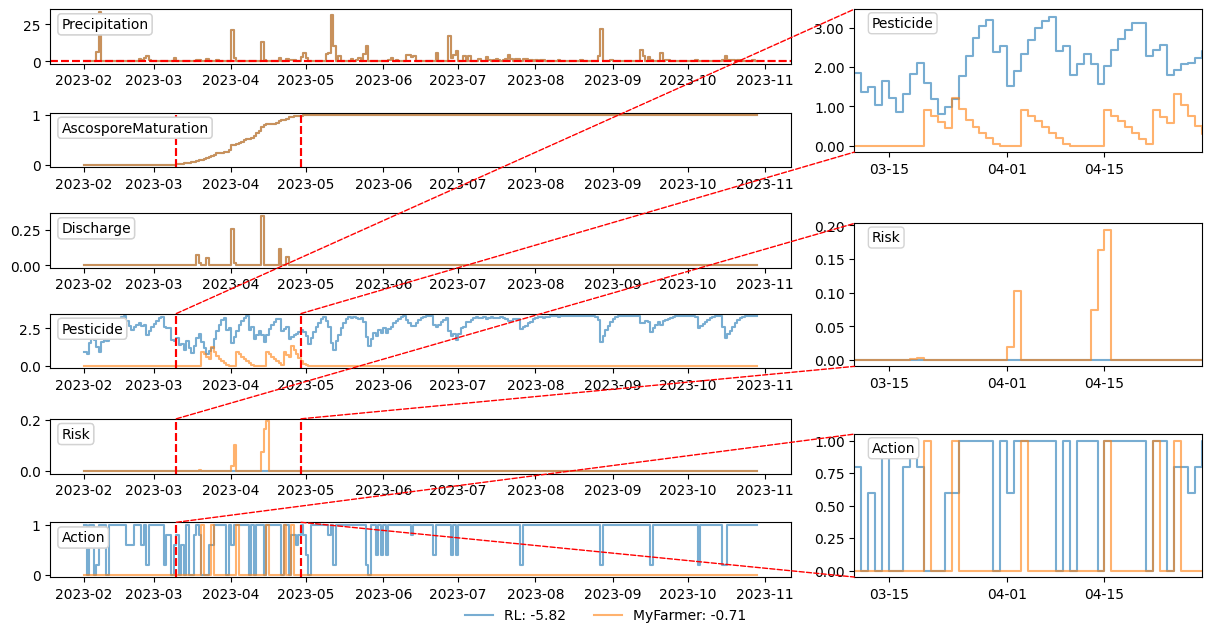

In [44]:
from ascab.utils.plot import plot_results


# First, make a dictionary of your agents
dict_to_plot = {"RL":rl_results,
             "MyFarmer":farmer_strategy_results,}

plot_results(dict_to_plot,
             save_path=os.getcwd(),
             per_year=True,
        )

How did your agent(s) do? Not satisfied? Try another strategy or RL agent!

### Want to train in your own machine? Or a crazy super-computer? Piece of cake!

Just install everything there, keeping in mind to use the `hackathon` branch from the A-scab repository, and download the training and testing data from the kaggle competition. Make sure to put both `train.csv` and `val.csv` are under `..\A-scab\dataset\`.

# Important things!

Last but not least, while we would like for you to enjoy the hackathon process, there are a few hard rules we would like to enforce:
1. No sharing models between teams.
2. All RL models must be trained in the given environment. No training with additional data or features!
3. Conditional agents are not permitted to use two features:
    - `"Risk"`, this is the target :)
    - `"Pesticide"`, this makes the agent cheat a bit, since it will know how much pesticide is left in the canopy.

We will manually check any model during testing and submission. Any violations could result in a disqualification from the leaderboard.

# Instructions for submitting your winning Agent

The testing will be done in an unseen location! Here are the instructions to submit your agent:

### For RL agents:

### For Conditional agents: